# House Prices Prediction using TensorFlow Decision Forests

This notebook walks you through how to train a baseline Random Forest model using TensorFlow Decision Forests on the House Prices dataset made available for this competition.

Roughly, the code will look as follows:

```
import tensorflow_decision_forests as tfdf
import pandas as pd

dataset = pd.read_csv("project/dataset.csv")
tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(dataset, label="my_label")

model = tfdf.keras.RandomForestModel()
model.fit(tf_dataset)

print(model.summary())
```

Decision Forests are a family of tree-based models including Random Forests and Gradient Boosted Trees. They are the best place to start when working with tabular data, and will often outperform (or provide a strong baseline) before you begin experimenting with neural networks.

## Import the library

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb

# Comment this if the data visualisations doesn't work on your side
%matplotlib inline

In [2]:
print("TensorFlow v" + tf.__version__)
print("TensorFlow Decision Forests v" + tfdf.__version__)

TensorFlow v2.11.0
TensorFlow Decision Forests v1.2.0


## Load the dataset


In [3]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)

In [4]:
dataset_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
dataset_df = dataset_df.drop('Id', axis=1)

## House Price Distribution

Now let us take a look at how the house prices are distributed.

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [6]:
list(set(dataset_df.dtypes.tolist()))

[dtype('float64'), dtype('O'), dtype('int64')]

In [7]:
dataset_df['YearsBtwRemod'] = dataset_df['YearRemodAdd']-dataset_df['YearBuilt']
dataset_df['TotalInnerSF'] = dataset_df['1stFlrSF']+dataset_df['2ndFlrSF']+dataset_df['TotalBsmtSF']
dataset_df['BedroomSize'] = round(dataset_df['1stFlrSF']+dataset_df['2ndFlrSF']/dataset_df['BedroomAbvGr'])

dataset_df.replace([np.inf, -np.inf], np.nan, inplace=True)
dataset_df.BedroomSize.fillna(0,inplace=True)
dataset_df_xgb = dataset_df.select_dtypes(include = ['float64', 'int64'])

In [8]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,YearsBtwRemod,TotalInnerSF,BedroomSize
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,2,2008,208500,0,2566,1141.0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,0,5,2007,181500,0,2524,1262.0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,9,2008,223500,1,2706,1209.0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,0,2,2006,140000,55,2473,1213.0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,12,2008,250000,0,3343,1408.0


Now let us plot the distribution for all the numerical features.

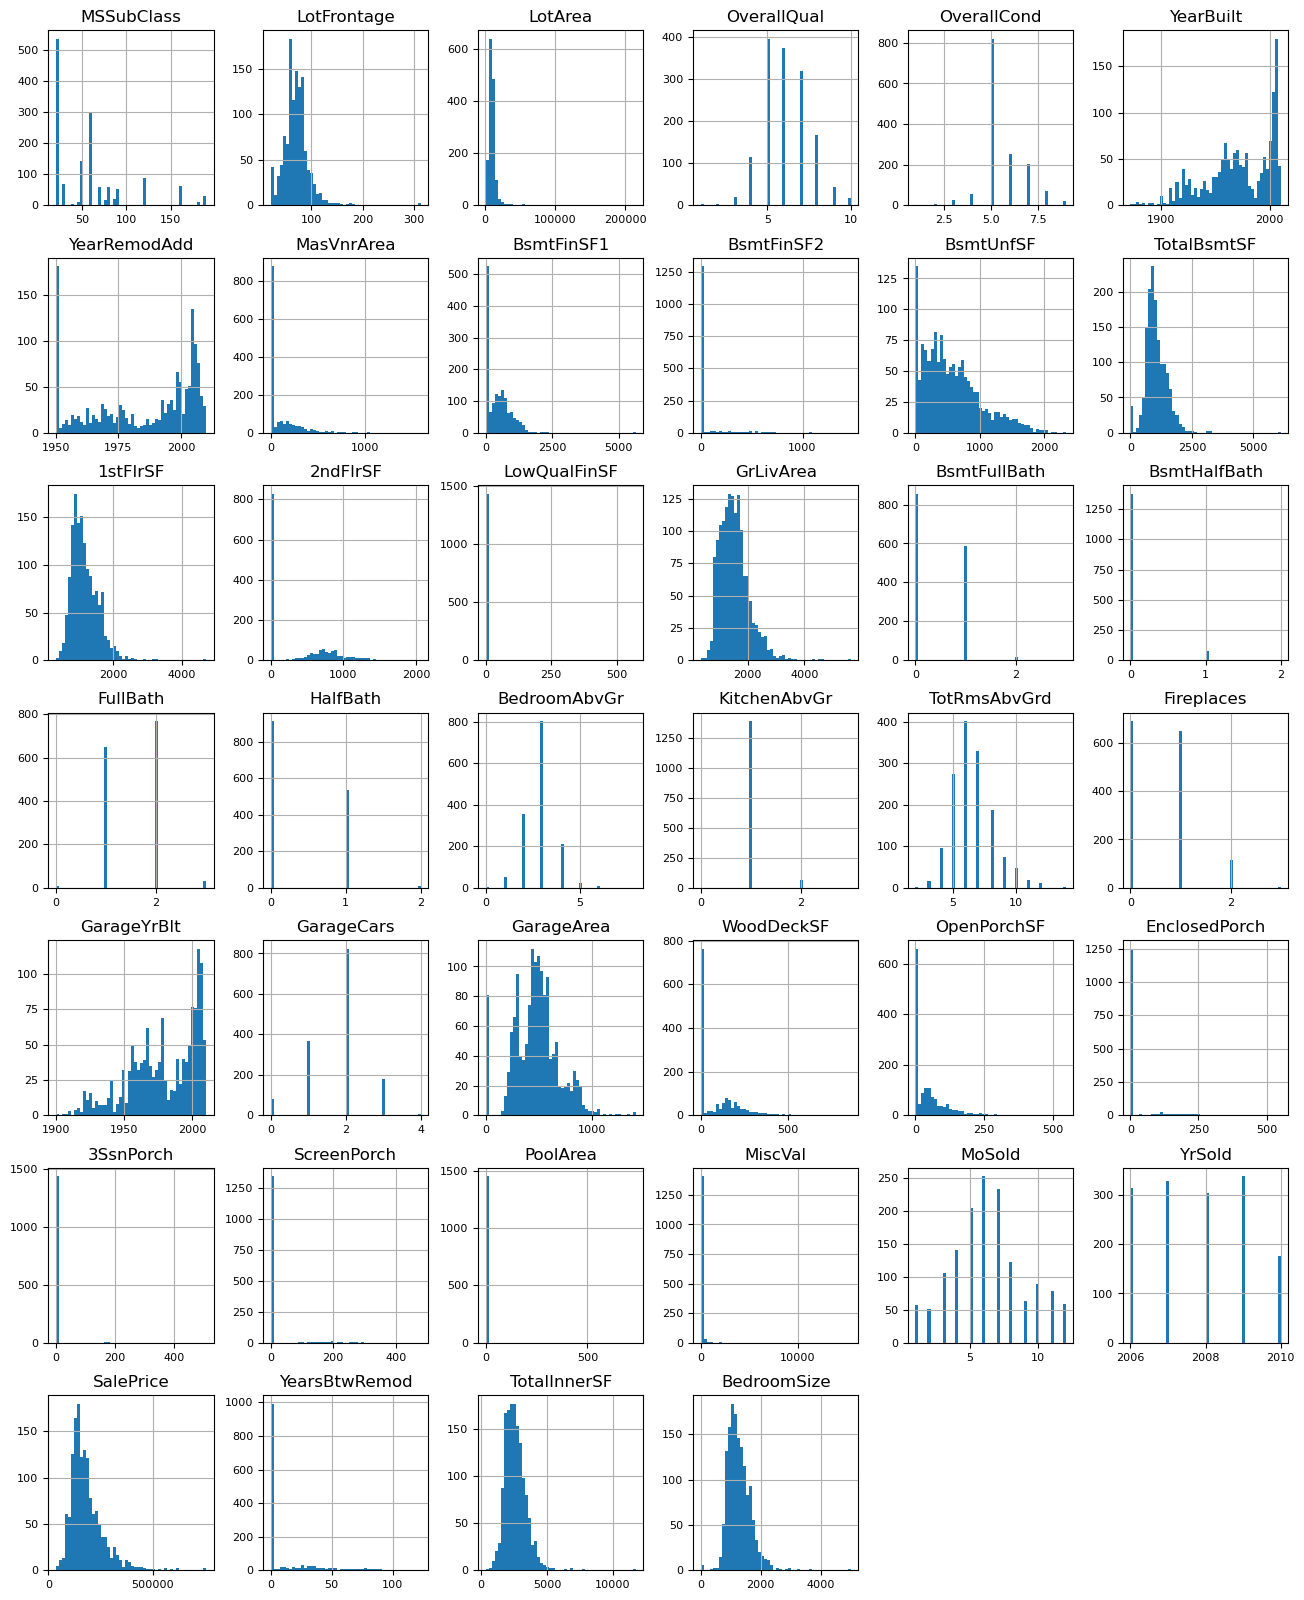

In [9]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

In [10]:
def split_dataset(dataset, test_ratio=0.28):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

train_ds_xgb, valid_ds_xgb = split_dataset(dataset_df_xgb)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_xgb), len(valid_ds_xgb)))

1053 examples in training, 407 examples in testing.
1058 examples in training, 402 examples in testing.


In [11]:
train_ds_xgb_np = train_ds_xgb.drop(['SalePrice'],axis=1)
valid_ds_xgb_np = valid_ds_xgb.drop(['SalePrice'],axis=1)

There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [12]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

## GBTM

In [13]:
tuner = tfdf.tuner.RandomSearch(num_trials=30)

# Hyper-parameters to optimize.
tuner.choice("max_depth", [4,5,6,7,15,60,150])
tuner.choice("min_examples", [2,4,5,6,7,15,50,150])
tuner.choice("num_trees",[5,20,40,70,80,100,200,300])
tuner.choice("selective_gradient_boosting_ratio",[0.0001,0.01,0.015,0.02,0.025,0.1,0.7])
tuner.choice("random_seed",[123456,12,1717,654646])

In [14]:
gbtm = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.REGRESSION, tuner=tuner)
gbtm.compile(metrics=["mse"]) # Optional, you can use this to include a list of eval metrics

Use /tmp/tmp61esa8i9 as temporary training directory


In [15]:
gbtm.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:07.563240. Found 1053 examples.
Training model...
Model trained in 0:00:20.175709
Compiling model...


[INFO 2024-03-06T02:53:21.062838973+00:00 kernel.cc:1214] Loading model from path /tmp/tmp61esa8i9/model/ with prefix 3273bb2f14b74079
[INFO 2024-03-06T02:53:21.073859305+00:00 abstract_model.cc:1311] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 2024-03-06T02:53:21.073983269+00:00 kernel.cc:1046] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


## XGB

In [16]:
reg = xgb.XGBRegressor(tree_method="hist", device="cuda")

In [17]:
reg.fit(train_ds_xgb_np, train_ds_xgb['SalePrice'], eval_set=[(train_ds_xgb_np, train_ds_xgb['SalePrice']),(valid_ds_xgb_np, valid_ds_xgb['SalePrice'])])

[02:53:27] WARNING: ../src/learner.cc:627: 
Parameters: { "device" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:141484.42914	validation_1-rmse:140371.24668
[1]	validation_0-rmse:101820.22243	validation_1-rmse:102018.94681
[2]	validation_0-rmse:74135.60467	validation_1-rmse:75727.92960
[3]	validation_0-rmse:54671.03061	validation_1-rmse:59355.01368
[4]	validation_0-rmse:40884.82230	validation_1-rmse:49645.07659
[5]	validation_0-rmse:31272.58692	validation_1-rmse:44694.35921
[6]	validation_0-rmse:24511.31716	validation_1-rmse:41714.33256
[7]	validation_0-rmse:19910.04007	validation_1-rmse:41381.85675
[8]	validation_0-rmse:16591.87201	validation_1-rmse:41333.01300
[9]	validation_0-rmse:14392.38027	validation_1-rmse:41850.15775

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0, ...)

gbtm training

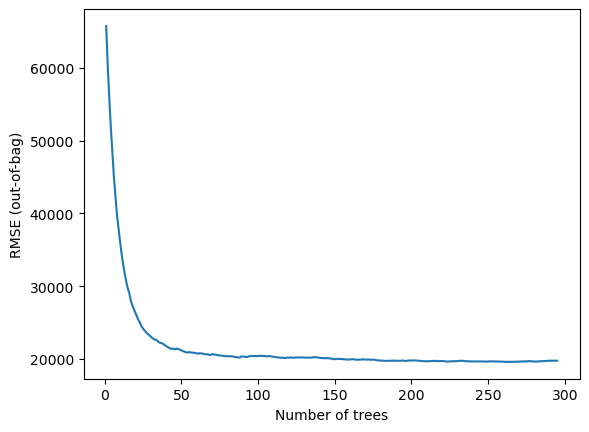

In [18]:
import matplotlib.pyplot as plt
logs = gbtm.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [19]:
inspector = gbtm.make_inspector()
inspector.evaluation()

Evaluation(num_examples=None, accuracy=None, loss=19588.83984375, rmse=19588.83984375, ndcg=None, aucs=None, auuc=None, qini=None)

Now, let us run an evaluation using the validation dataset.

In [20]:
evaluation = gbtm.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 2s 2s/step - loss: 0.0000e+00 - mse: 825847616.0000
loss: 0.0000
mse: 825847616.0000


## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [21]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 NUM_NODES
	 SUM_SCORE


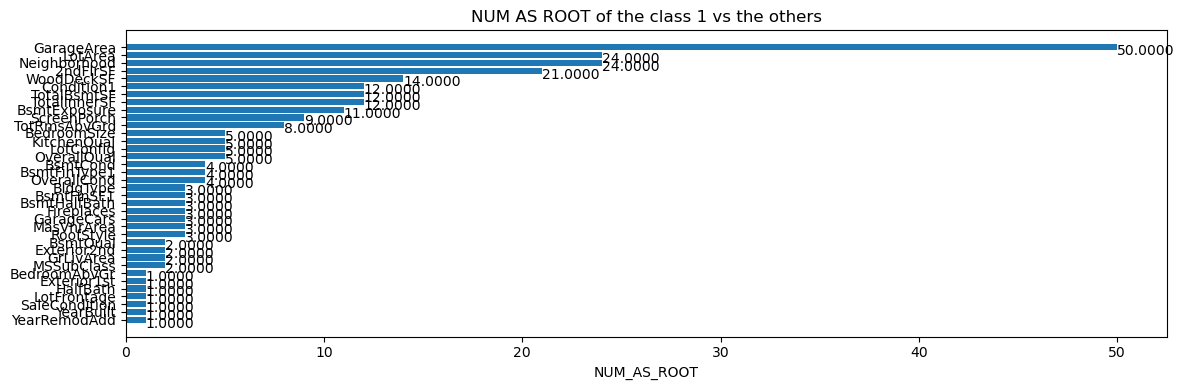

In [22]:
inspector.variable_importances()["NUM_AS_ROOT"]

plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

XGB Feature Importance

In [23]:
print(reg.feature_names_in_)
print(reg.feature_importances_)

['MSSubClass' 'LotFrontage' 'LotArea' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'BsmtUnfSF' 'TotalBsmtSF' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF'
 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'TotRmsAbvGrd' 'Fireplaces' 'GarageYrBlt'
 'GarageCars' 'GarageArea' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch'
 '3SsnPorch' 'ScreenPorch' 'PoolArea' 'MiscVal' 'MoSold' 'YrSold'
 'YearsBtwRemod' 'TotalInnerSF' 'BedroomSize']
[7.6518569e-04 8.6016289e-04 3.1586986e-03 3.0363566e-01 5.1384605e-03
 1.2703285e-02 1.0484341e-02 3.2129225e-03 5.3883130e-03 6.9446489e-04
 5.9832111e-03 1.6941408e-03 2.9940875e-03 1.0863955e-02 6.1938306e-05
 1.1996078e-02 2.1459949e-03 7.8588113e-05 3.4595965e-03 1.1872915e-03
 1.8628170e-03 3.4136947e-02 1.0676980e-02 1.0434345e-02 7.2545270e-03
 9.4837211e-02 3.9791376e-03 2.4385233e-03 2.3280471e-03 2.7742218e-03
 2.2013164e-03 1.4796464e-03 4.9564042e-03 6.3349877e-04

Plot the variable importances from the inspector using Matplotlib

# Submission
Finally predict on the competition test data using the model.

In [24]:
test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)


test_data['YearsBtwRemod'] = test_data['YearRemodAdd']-test_data['YearBuilt']
test_data['TotalInnerSF'] = test_data['1stFlrSF']+test_data['2ndFlrSF']+test_data['TotalBsmtSF']
test_data['BedroomSize'] = round(test_data['1stFlrSF']+test_data['2ndFlrSF']/test_data['BedroomAbvGr'])

test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.BedroomSize.fillna(0,inplace=True)

ids = test_data.pop('Id')


test_data_xgb = test_data.select_dtypes(include = ['float64', 'int64'])

In [25]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task = tfdf.keras.Task.REGRESSION)

XGB Prediction

In [26]:
p1 = reg.predict(test_data_xgb)

GBTM Prediction

In [27]:
preds = gbtm.predict(test_ds)
output = pd.DataFrame({'Id': ids,
                       'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 15ms/step


,Id,SalePrice
0,1461,114053.328125
1,1462,171304.328125
2,1463,195062.031250
3,1464,192577.234375
4,1465,188339.531250


In [28]:
sample_submission_df = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
#sample_submission_df['SalePrice'] = gbtm.predict(test_ds)
sample_submission_df['SalePrice'] = reg.predict(test_data_xgb)
sample_submission_df.to_csv('/kaggle/working/submission9.csv', index=False)
sample_submission_df.head()

,Id,SalePrice
0,1461,132075.234375
1,1462,157999.640625
2,1463,207336.796875
3,1464,194707.703125
4,1465,175602.750000
